In [4]:
import matplotlib.pyplot as plt
import numpy as np
import wave
from random import sample
import pandas as pd
from scipy import fftpack
from scipy.signal import butter, filtfilt
from statsmodels.graphics.tsaplots import plot_acf
import plotly.graph_objects as go 
import os
from difflib import SequenceMatcher
# from tsfeatures import tsfeatures

# Plotting

In [2]:
def plot_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    Time = np.linspace(0, len(signal) / fs, num=len(signal))

    plt.figure(1)
    title = str(path.split("arm_signal/")[-1])
    
    plt.title(title)
    plt.plot(Time[::100], signal[::100], color = 'dodgerblue')
    plt.show()






# Classifier

/opt/anaconda3/envs/psycopg2/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


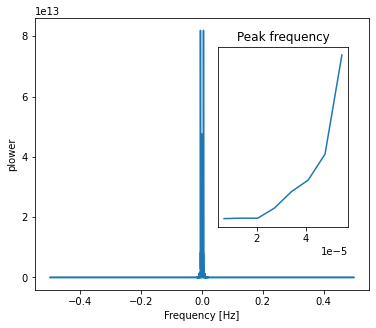

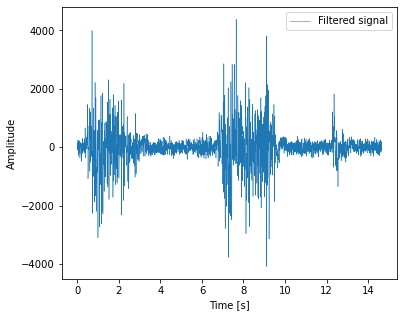

In [4]:
def filter_plot(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    sig_fft = fftpack.fft(sig)
    power = np.abs(sig_fft)**2
    period = 5

    # The corresponding frequencies
    sample_freq = fftpack.fftfreq(sig.size)

    # Plot the FFT power
    plt.figure(figsize=(6, 5))
    plt.plot(sample_freq, power)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('plower')

    # Find the peak frequency: we can focus on only the positive frequencies
    pos_mask = np.where(sample_freq > 0)
    freqs = sample_freq[pos_mask]
    peak_freq = freqs[power[pos_mask].argmax()]

    # Check that it does indeed correspond to the frequency that we generate
    # the signal with
    np.allclose(peak_freq, 1./period)

    # An inner plot to show the peak frequency
    axes = plt.axes([0.55, 0.3, 0.3, 0.5])
    plt.title('Peak frequency')
    plt.plot(freqs[:8], power[:8])
    plt.setp(axes, yticks=[])   

    high_freq_fft = sig_fft.copy()
    high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
    filtered_sig = fftpack.ifft(high_freq_fft)

    plt.figure(figsize=(6, 5))
    plt.plot(Time, filtered_sig, linewidth=0.5, label='Filtered signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.legend(loc='best')
filter_plot("/Users/martinhuang/Desktop/OneDrive/2022/2022 Sem 1/DATA3888/Brain 5/Brain/arm_signal/EEU.wav")


In [9]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, fs, time, spf 

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.3*fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y
    
def fft(path, cutoff = 5, plot = False):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    Time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    y = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = y,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    return y, Time 

    
    

In [6]:

def movement_classifier(data, time, down_sample_rate = 50, window_size = 0.3, threshold_events = 100, difference = 0.4):
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)

    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)

    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]

    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)

    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0

    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]
                    
    return intervals

# Preparing Wave File

In [7]:
def prep_wave(path):
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()

    time = np.linspace(0, len(signal) / fs, num=len(signal))
    return signal, time 

In [8]:
def predict(intervals):
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")

In [16]:
def extract_signal(limit, data):
    if limit[0] >= limit[1]:
        print("Error")
        return [0] 
    ret_data = []
    for i in range(len(data)):
        if i >= limit[0] and i < limit[1]:
            ret_data.append(data[i])
    return ret_data

In [17]:
signal_UUU, time = fft("arm_signal/UUU.wav")
intervals = movement_classifier(signal_UUU, time, down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3)
print(intervals[0])

a = extract_signal(intervals[1], signal_UUU)
print(a)

[0.666, 0.986]
[56.527862172953775]


# Finish Classifier


In [7]:
def predict_wave(path,down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.3, plot = False, cutoff = 5):
    t = 5
    path = str(path)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    time = np.linspace(0, len(signal) / fs, num=len(signal))
    sig = signal 
    cutoff = cutoff
    order = 2
    data  = butter_lowpass_filter(signal, cutoff, fs, order)

    if plot == True:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
                    y = signal,
                    line =  dict(shape =  'spline' ),
                    name = 'signal with noise'
                    ))
        fig.add_trace(go.Scatter(
                    y = data,
                    line =  dict(shape =  'spline' ),
                    name = 'filtered signal'
                    ))

        fig.show()
    # 1. Down Sampling
    ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
    t_stat = [0]*len(ind)
    # 2. Calculating SD
    for i in range(len(ind)):
        data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
        t_stat[i] = np.std(data_subset)
    # 3. Use threshold to determine movement intervals
    predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]
    # time vector for middle of each window 
    time_middle = []
    for i in predicted_event:
        time_middle.append(time[ind[i]] + window_size/2)
    # 4. Estimation 
    intervals = [] 
    cut_point = predicted_event[0]
    last_interval = 0
    middle_time = int(down_sample_rate * window_size/2)
    for i in range(len(predicted_event) - 1):
        if predicted_event[i+1] != predicted_event[i] + 1:
            # combine intervals together if the predicted intervals are with difference amount
            if last_interval == 0:
                intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            else:
                if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                    last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                else:
                    intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                last_interval = intervals[-1]
            
            cut_point = predicted_event[i+1]             
    for i in range(len(intervals)):
        if intervals[i][1] - intervals[i][0] < 1:
            print("Turn")
        elif intervals[i][1] - intervals[i][0] >= 1:
            print("Tension")
    
  


In [18]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [16]:
def accuracy(folder_path = "arm_signal/", down_sample_rate = 80, window_size = 0.5, threshold_events = 12, difference = 1.25, cutoff = 5, classifier_interval = 1.1, plot = True, printt = True, accuracy_output = True):
    path = str(folder_path)
    directory = os.fsencode(path)
    accuracy = []
    number_of_files = 0
    for file in os.listdir(directory):
        number_of_files += 1
        filename = os.fsdecode(file)
        if filename.endswith(".wav") == False:
               continue 
        else:
            path = str(folder_path + filename)
            spf = wave.open(path, "r")
            signal = spf.readframes(-1)
            signal = np.frombuffer(signal, np.int16)
            fs = spf.getframerate()
            time = np.linspace(0, len(signal) / fs, num=len(signal))
            cutoff = cutoff
            order = 2
            data  = butter_lowpass_filter(signal, cutoff, fs, order)
            # 1. Down Sampling
            ind = np.arange(0, np.where(np.round(time,4) == round(time[len(time) - 1] - window_size, 4))[0][0], down_sample_rate)
            t_stat = [0]*len(ind)
            # 2. Calculating SD
            for i in range(len(ind)):
                data_subset = data[ind[i] : ind[i] + int(window_size * down_sample_rate)]
                t_stat[i] = np.std(data_subset)
            # 3. Use threshold to determine movement intervals
            predicted_event = [x for x in range(len(t_stat)) if t_stat[x] > threshold_events]
            # time vector for middle of each window 
            time_middle = []
            for i in predicted_event:
                time_middle.append(time[ind[i]] + window_size/2)
            # 4. Estimation 
            intervals = [] 
            cut_point = predicted_event[0]
            last_interval = 0
            middle_time = int(down_sample_rate * window_size/2)
            for i in range(len(predicted_event) - 1):
                if predicted_event[i+1] != predicted_event[i] + 1:
                    # combine intervals together if the predicted intervals are with difference amount
                    if last_interval == 0:
                        intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                        last_interval = intervals[-1]
                    else:
                        if ((int(ind[cut_point] + middle_time)/10000) - last_interval[1]) < difference:
                            last_interval[1] = int(ind[predicted_event[i]] + middle_time)/10000
                        else:
                            intervals.append([int(ind[cut_point] + middle_time)/10000, int(ind[predicted_event[i]] + middle_time)/10000])
                        last_interval = intervals[-1]
                    cut_point = predicted_event[i+1] 
          
          
        if accuracy_output == True:
            correct = filename.split(".")[0] 
            correct = ''.join([i for i in correct if not i.isdigit()])
            correct_answer = list(correct)
            estimate = [] 
            for i in range(len(intervals)):
                if intervals[i][1] - intervals[i][0] < classifier_interval:
                    estimate.append("U")
                elif intervals[i][1] - intervals[i][0] >= classifier_interval:
                    estimate.append("E")
            counter = 0
            acc = 0
            # for i in correct_answer:
            #     if counter > len(correct_answer):
            #         continue
            #     if counter <= len(correct_answer):
            #         if i == estimate[counter]:
            #             acc += 1
            #             counter += 1
            #         else:
            #             counter += 1
 
            # similar(correct_answer, estimate)
        # accuracy.append(acc/len(correct_answer))
        accuracy.append(similar(correct_answer, estimate))
    
    if plot == True:
        plt.boxplot(accuracy)
        plt.show()
    nparr = np.array(accuracy)
    acc_value = np.sum(nparr)/len(nparr)
    # acc_value = sum(int(accuracy))/len(accuracy)
    if printt == True:
        print("From",folder_path.strip(" "), ":", "accuracy is", round(acc_value,3), "from",number_of_files,"files and",number_of_files*len(correct_answer),"events.")

    if accuracy_output == False:
        return estimate
    else:
        return round(acc_value,3)
        
        


            
            
     

In [35]:
# signal,time = prep_wave("arm_signal/UUU.wav")

wave_seq_short_whole = [] 
intervals_whole = [] 
transformed = [] 
sample_rate = 10000

folder_path = "arm_signal/"
path = str(folder_path)
directory = os.fsencode(path)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".wav") == False:
        continue 
    path = str(folder_path + filename)
    spf = wave.open(path, "r")
    signal = spf.readframes(-1)
    signal = np.frombuffer(signal, np.int16)
    fs = spf.getframerate()
    time = np.linspace(0, len(signal) / fs, num=len(signal))
    cutoff = 5
    order = 2
    data  = butter_lowpass_filter(signal, cutoff, fs, order)
    intervals = movement_classifier(data, time, 80,0.5,12,1.3) 
    intervals_whole.extend(intervals)   

    wave_seq_short = [] 
    for i in range(len(intervals)):
        wave_seq_short.append(extract_signal(intervals[i], data))
    wave_seq_short_whole.extend(wave_seq_short)
    print(filename, len(wave_seq_short))


panel_whole = pd.DataFrame(columns = ['unique_id','ds','y'])
for i in range(len(wave_seq_short_whole)):
    if intervals_whole[i][0] < intervals_whole[i][1]:
        unique_id = [i]*len(wave_seq_short_whole[i])
        time = np.arange(intervals_whole[i][0],intervals_whole[i][1])/sample_rate 
        panel = pd.DataFrame(data = {'unique_id':unique_id,
                                     'ds':time,
                                     'y':wave_seq_short[i]})
        panel_whole = panel_whole.append(panel, ignore_index = True)

print("Done")

UUE2.wav 3
UUE3.wav 3
UEU2.wav 3
UEU3.wav 3
EEE.wav 3
EEU2.wav 3
UUU.wav 3
EEU3.wav 3
EUE2.wav 3
UUE.wav 3
EUE3.wav 3
EEU.wav 3
UEE3.wav 3
UEE2.wav 3
UUU3.wav 3
UUU2.wav 3
EUU3.wav 3
EUU.wav 3
EUU2.wav 3
UEE.wav 3
UEU.wav 3
EEE3.wav 3
EUE.wav 3
EEE2.wav 3


ValueError: arrays must all be same length

Loading... 1 / 32
Loading... 2 / 32
Loading... 3 / 32
Loading... 4 / 32
Loading... 5 / 32
Loading... 6 / 32
Loading... 7 / 32
Loading... 8 / 32
Loading... 9 / 32
Loading... 10 / 32
Loading... 11 / 32
Loading... 12 / 32
Accuracy: 0.808 Difference: 1.1000000000000005 Classifier Interval: 1.1 D Counter: 12 C Counter: 264
Loading... 13 / 32
Loading... 14 / 32
Accuracy: 0.803 Difference: 1.2000000000000006 Classifier Interval: 1.1 D Counter: 14 C Counter: 306
Loading... 15 / 32
Accuracy: 0.809 Difference: 1.2500000000000007 Classifier Interval: 1.1 D Counter: 15 C Counter: 327
Loading... 16 / 32
Accuracy: 0.801 Difference: 1.3000000000000007 Classifier Interval: 1.1 D Counter: 16 C Counter: 348
Loading... 17 / 32
Loading... 18 / 32
Loading... 19 / 32
Loading... 20 / 32
Loading... 21 / 32
Loading... 22 / 32
Loading... 23 / 32
Loading... 24 / 32
Loading... 25 / 32
Loading... 26 / 32
Loading... 27 / 32
Loading... 28 / 32
Loading... 29 / 32
Loading... 30 / 32
Loading... 31 / 32
Loading... 32 / 

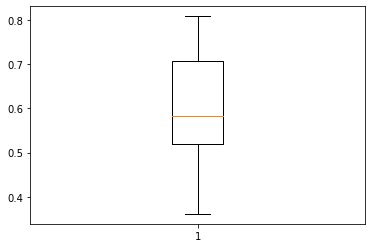

Highest Accuracy: 0.809


In [87]:

acc = []
difference_test = np.arange(0.5,2.1, 0.05)
classifier_interval_test = np.arange(0,2.1,0.1)
counter = 0
difference_counter = 0
classifier_counter = 0
for difference in difference_test:
    for classifier_interval in classifier_interval_test:
        a = accuracy("ear_all/", difference = difference, plot = False, classifier_interval = classifier_interval, printt = False)
        acc.append(a)
        classifier_counter += 1
        if a >= 0.80:
            print("Accuracy:", a, "Difference:",difference,"Classifier Interval:",classifier_interval, "D Counter:",difference_counter,"C Counter:",classifier_counter)
    counter += 1
    difference_counter += 1
    print("Loading...", counter,"/",len(difference_test))
plt.boxplot(acc)
plt.show()
print("Highest Accuracy:",max(acc))
# print("Total Accuracy between 3 files is", round(sum(acc)/3,3))
# print(difference_test)



# We tested that from 0 to 0.5 in differences, there is no significant accuracy scores. Let us start from 0.5 onwards.

In [12]:
paths = ["ear_all/","shoulder/","wrist/","Yuxuan/wrist/","Yuxuan/elbw/","Yuxuan/shoulder/"]
for i in paths:
    accuracy(i, difference = 1.3, plot = False, classifier_interval = 1)

From ear_all/ : accuracy is 0.795 from 38 files and 114 events.
From shoulder/ : accuracy is 0.475 from 8 files and 24 events.
From wrist/ : accuracy is 0.454 from 8 files and 24 events.
From Yuxuan/wrist/ : accuracy is 0.45 from 8 files and 24 events.
From Yuxuan/elbw/ : accuracy is 0.392 from 8 files and 24 events.
From Yuxuan/shoulder/ : accuracy is 0.329 from 8 files and 24 events.


In [14]:
for i in paths:
    accuracy(i, difference = 1.25, classifier_interval = 1.1, plot = False)

From ear_all/ : accuracy is 0.809 from 38 files and 114 events.
From shoulder/ : accuracy is 0.475 from 8 files and 24 events.
From wrist/ : accuracy is 0.454 from 8 files and 24 events.
From Yuxuan/wrist/ : accuracy is 0.4 from 8 files and 24 events.
From Yuxuan/elbw/ : accuracy is 0.392 from 8 files and 24 events.
From Yuxuan/shoulder/ : accuracy is 0.367 from 8 files and 24 events.


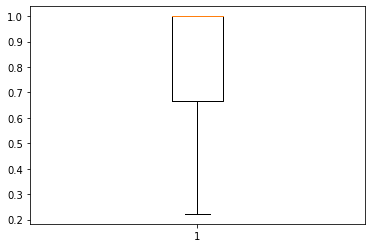

From ear_all/ : accuracy is 0.809 from 38 files and 114 events.


0.809

In [19]:
accuracy("ear_all/", difference = 1.25, classifier_interval = 1.1)